In [1]:
###SVM model

Input file: C:\ROOT\CK2 code\figure1D\IC50_formodel_fp_standard.csv
Fitting 10 folds for each of 18 candidates, totalling 180 fits


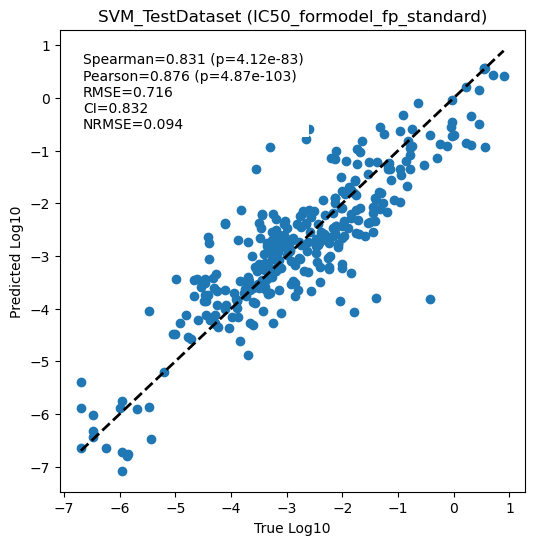

==== All done ====
CV results saved to: C:\ROOT\CK2 code\figure1D\parameter\SVM_IC50_formodel_fp_standard_CVResults.csv
Model saved to: C:\ROOT\CK2 code\figure1D\parameter\SVM_IC50_formodel_fp_standard_best_model.pkl
Plot saved to: C:\ROOT\CK2 code\figure1D\plot\SVM_IC50_formodel_fp_standard_test.pdf
Summary saved to: C:\ROOT\CK2 code\figure1D\parameter\SVM_summary.csv


,file,abs_path,n_samples_total,n_features,best_params,best_cv_neg_mse,test_spearman,test_spearman_p,test_pearson,test_pearson_p,test_rmse,test_ci,test_nrmse,cv_results_csv,model_pkl,test_plot_pdf
0,IC50_formodel_fp_standard.csv,C:\ROOT\CK2 code\figure1D\IC50_formodel_fp_sta...,1282,1024,"{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}",-0.511502,0.830629,4.115505e-83,0.876001,4.874016e-103,0.716163,0.831715,0.094298,C:\ROOT\CK2 code\figure1D\parameter\SVM_IC50_f...,C:\ROOT\CK2 code\figure1D\parameter\SVM_IC50_f...,C:\ROOT\CK2 code\figure1D\plot\SVM_IC50_formod...


In [2]:
%matplotlib inline

# =========================
# Basic libraries / 基础库
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr, pearsonr
from lifelines.utils import concordance_index
import pickle


# ============================================================
# 1) Path configuration / 路径配置（根据本地环境自行修改）
# ============================================================
data_path = Path(r"C:\\ROOT\\CK2 code\\figure1D")
parameter_path = data_path / "parameter"
plot_path = data_path / "plot"

parameter_path.mkdir(parents=True, exist_ok=True)
plot_path.mkdir(parents=True, exist_ok=True)

# 单一输入文件（你现在的情况）
input_file = data_path / "IC50_formodel_fp_standard.csv"
if not input_file.exists():
    raise FileNotFoundError(f"Input file not found: {input_file}")

print("Input file:", input_file)


# ============================================================
# 2) Global configuration / 全局参数设置
# ============================================================
SPLIT_SEED = 0
TRAIN_SIZE = 0.75

param_grid = {
    "C": [0.1, 1, 10],
    "kernel": ["linear", "rbf"],
    "gamma": [1, 0.1, 0.01],
}

drop_cols_default = [
    "Unnamed: 0",
    "realsmiles",
    "is_biochemical",
    "Log10",
    "is_cellbased",
    "id",
    "type",
    "value",
]


# ============================================================
# 3) Utility functions / 工具函数
# ============================================================
def safe_drop(df: pd.DataFrame, cols):
    cols_exist = [c for c in cols if c in df.columns]
    return df.drop(cols_exist, axis=1)


def compute_metrics(y_true, y_pred):
    sp = spearmanr(y_true, y_pred)
    pe = pearsonr(y_true, y_pred)
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))

    denom = float(np.max(y_true) - np.min(y_true))
    nrmse = float(rmse / denom) if denom != 0 else np.nan

    ci = float(concordance_index(y_true, y_pred))
    return sp, pe, rmse, nrmse, ci


def scatter_plot(y_true, y_pred, title, xlabel, ylabel, out_file: Path):
    sp, pe, rmse, nrmse, ci = compute_metrics(y_true, y_pred)

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(y_true, y_pred)

    mn, mx = float(np.min(y_true)), float(np.max(y_true))
    ax.plot([mn, mx], [mn, mx], "k--", lw=2)

    text = (
        f"Spearman={sp.statistic:.3f} (p={sp.pvalue:.2e})\n"
        f"Pearson={pe.statistic:.3f} (p={pe.pvalue:.2e})\n"
        f"RMSE={rmse:.3f}\n"
        f"CI={ci:.3f}\n"
        f"NRMSE={nrmse:.3f}"
    )

    ax.text(
        0.05, 0.95, text,
        transform=ax.transAxes,
        ha="left", va="top",
        bbox={"facecolor": "white", "edgecolor": "none"},
    )

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    fig.savefig(out_file, dpi=500, bbox_inches="tight")
    plt.show()


# ============================================================
# 4) Main: load -> split -> grid search -> evaluate -> save
# ============================================================
tag = input_file.stem  # "IC50_formodel_fp_standard"

# Load dataset
df = pd.read_csv(input_file, sep=",")

# Column name normalization
if "is_cell.based" in df.columns and "is_cellbased" not in df.columns:
    df.rename(columns={"is_cell.based": "is_cellbased"}, inplace=True)

# Build X, y
if "Log10" not in df.columns:
    raise ValueError(f"{input_file.name} does not contain 'Log10' column.")

X = safe_drop(df, drop_cols_default)
y = df["Log10"].values

# Safety checks
assert X.select_dtypes(exclude=[np.number]).shape[1] == 0, f"{input_file.name}: X contains non-numeric columns!"
assert np.isfinite(X.to_numpy()).all(), f"{input_file.name}: X contains NaN/inf!"
assert np.isfinite(y).all(), f"{input_file.name}: y contains NaN/inf!"

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=TRAIN_SIZE, random_state=SPLIT_SEED
)

# GridSearchCV
base_model = SVR(kernel="rbf", C=1.0, gamma="scale")

grid = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=10,
    n_jobs=-1,
    verbose=1,
)

grid.fit(X_train, y_train)

# Save CV results
cv_results = pd.DataFrame(grid.cv_results_)
cv_results_out = parameter_path / f"SVM_{tag}_CVResults.csv"
cv_results.to_csv(cv_results_out, index=False)

# Best model
best_model = grid.best_estimator_

# Test evaluation
y_pred_test = best_model.predict(X_test)
sp_te, pe_te, rmse_te, nrmse_te, ci_te = compute_metrics(y_test, y_pred_test)

# Save model
model_out = parameter_path / f"SVM_{tag}_best_model.pkl"
with open(model_out, "wb") as f:
    pickle.dump(best_model, f)

# Plot
test_plot_out = plot_path / f"SVM_{tag}_test.pdf"
scatter_plot(
    y_test,
    y_pred_test,
    title=f"SVM_TestDataset ({tag})",
    xlabel="True Log10",
    ylabel="Predicted Log10",
    out_file=test_plot_out,
)

# Summary 
summary_df = pd.DataFrame([{
    "file": input_file.name,
    "abs_path": str(input_file),
    "n_samples_total": int(len(df)),
    "n_features": int(X.shape[1]),
    "best_params": grid.best_params_,
    "best_cv_neg_mse": float(grid.best_score_),
    "test_spearman": float(sp_te.statistic),
    "test_spearman_p": float(sp_te.pvalue),
    "test_pearson": float(pe_te.statistic),
    "test_pearson_p": float(pe_te.pvalue),
    "test_rmse": float(rmse_te),
    "test_ci": float(ci_te),
    "test_nrmse": float(nrmse_te),
    "cv_results_csv": str(cv_results_out),
    "model_pkl": str(model_out),
    "test_plot_pdf": str(test_plot_out),
}])

summary_out = parameter_path / "SVM_summary.csv"
summary_df.to_csv(summary_out, index=False)

print("==== All done ====")
print("CV results saved to:", cv_results_out)
print("Model saved to:", model_out)
print("Plot saved to:", test_plot_out)
print("Summary saved to:", summary_out)

summary_df


In [3]:
### RF model###

Input file: C:\ROOT\CK2 code\figure1D\IC50_formodel_fp_standard.csv
Fitting 10 folds for each of 6 candidates, totalling 60 fits


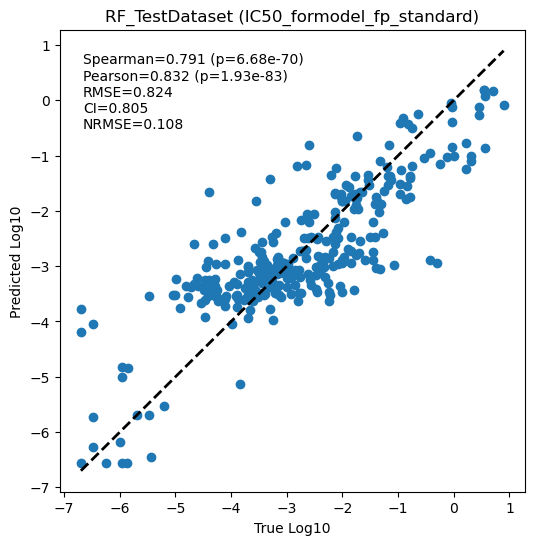

==== All done ====
CV results saved to: C:\ROOT\CK2 code\figure1D\parameter\RF_IC50_formodel_fp_standard_CVResults.csv
Model saved to: C:\ROOT\CK2 code\figure1D\parameter\RF_IC50_formodel_fp_standard_best_model.pkl
Plot saved to: C:\ROOT\CK2 code\figure1D\plot\RF_IC50_formodel_fp_standard_test.pdf
Summary saved to: C:\ROOT\CK2 code\figure1D\parameter\RF_summary.csv


,file,abs_path,n_samples_total,n_features,best_params,best_cv_neg_mse,test_spearman,test_spearman_p,test_pearson,test_pearson_p,test_rmse,test_ci,test_nrmse,cv_results_csv,model_pkl,test_plot_pdf
0,IC50_formodel_fp_standard.csv,C:\ROOT\CK2 code\figure1D\IC50_formodel_fp_sta...,1282,1024,"{'max_depth': 6, 'n_estimators': 500}",-0.623602,0.790515,6.680157e-70,0.83151,1.931806e-83,0.823867,0.805026,0.10848,C:\ROOT\CK2 code\figure1D\parameter\RF_IC50_fo...,C:\ROOT\CK2 code\figure1D\parameter\RF_IC50_fo...,C:\ROOT\CK2 code\figure1D\plot\RF_IC50_formode...


In [4]:
%matplotlib inline

# =========================
# Basic libraries / 基础库
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr, pearsonr
from lifelines.utils import concordance_index
import pickle


# ============================================================
# 1) Path configuration / 路径配置（根据本地环境自行修改）
# ============================================================
data_path = Path(r"C:\\ROOT\\CK2 code\\figure1D")

parameter_path = data_path / "parameter"
plot_path = data_path / "plot"

parameter_path.mkdir(parents=True, exist_ok=True)
plot_path.mkdir(parents=True, exist_ok=True)

# 单一输入文件（你现在的情况）
input_file = data_path / "IC50_formodel_fp_standard.csv"
if not input_file.exists():
    raise FileNotFoundError(f"Input file not found: {input_file}")

print("Input file:", input_file)


# ============================================================
# 2) Global configuration / 全局参数设置
# ============================================================
SPLIT_SEED = 0            # Random seed for train/test split / 数据集划分随机种子
MODEL_SEED = 42           # Random seed for RF model / RF 模型随机种子
TRAIN_SIZE = 0.75         # Train-test split ratio / 训练集比例

# Hyperparameter grid for RF / RF 网格搜索参数
param_grid = {
    "max_depth": [4, 6],
    "n_estimators": [10, 100, 500],
}

drop_cols_default = [
    "Unnamed: 0",
    "realsmiles",
    "is_biochemical",
    "Log10",
    "is_cellbased",
    "id",
    "type",
    "value",
]


# ============================================================
# 3) Utility functions / 工具函数
# ============================================================
def safe_drop(df: pd.DataFrame, cols):
    """Safely drop columns that exist in the DataFrame."""
    cols_exist = [c for c in cols if c in df.columns]
    return df.drop(cols_exist, axis=1)


def compute_metrics(y_true, y_pred):
    """Compute evaluation metrics for regression."""
    sp = spearmanr(y_true, y_pred)
    pe = pearsonr(y_true, y_pred)
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))

    denom = float(np.max(y_true) - np.min(y_true))
    nrmse = float(rmse / denom) if denom != 0 else np.nan

    ci = float(concordance_index(y_true, y_pred))
    return sp, pe, rmse, nrmse, ci


def scatter_plot(y_true, y_pred, title, xlabel, ylabel, out_file: Path):
    """Generate scatter plot with performance statistics."""
    sp, pe, rmse, nrmse, ci = compute_metrics(y_true, y_pred)

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(y_true, y_pred)

    mn, mx = float(np.min(y_true)), float(np.max(y_true))
    ax.plot([mn, mx], [mn, mx], "k--", lw=2)

    text = (
        f"Spearman={sp.statistic:.3f} (p={sp.pvalue:.2e})\n"
        f"Pearson={pe.statistic:.3f} (p={pe.pvalue:.2e})\n"
        f"RMSE={rmse:.3f}\n"
        f"CI={ci:.3f}\n"
        f"NRMSE={nrmse:.3f}"
    )

    ax.text(
        0.05, 0.95, text,
        transform=ax.transAxes,
        ha="left", va="top",
        bbox={"facecolor": "white", "edgecolor": "none"},
    )

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    fig.savefig(out_file, dpi=500, bbox_inches="tight")
    plt.show()


# ============================================================
# 4) Main: load -> split -> grid search -> evaluate -> save
# ============================================================
tag = input_file.stem  # "IC50_formodel_fp_standard"

# Load dataset
df = pd.read_csv(input_file, sep=",")

# Column name normalization
if "is_cell.based" in df.columns and "is_cellbased" not in df.columns:
    df.rename(columns={"is_cell.based": "is_cellbased"}, inplace=True)

# Build X, y
if "Log10" not in df.columns:
    raise ValueError(f"{input_file.name} does not contain 'Log10' column.")

X = safe_drop(df, drop_cols_default)
y = df["Log10"].values

# Safety checks
assert X.select_dtypes(exclude=[np.number]).shape[1] == 0, f"{input_file.name}: X contains non-numeric columns!"
assert np.isfinite(X.to_numpy()).all(), f"{input_file.name}: X contains NaN/inf!"
assert np.isfinite(y).all(), f"{input_file.name}: y contains NaN/inf!"

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=TRAIN_SIZE, random_state=SPLIT_SEED
)

# GridSearchCV (RF)
base_model = RandomForestRegressor(
    random_state=MODEL_SEED,
    n_jobs=-1
)

grid = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=10,
    n_jobs=-1,
    verbose=1,
)

grid.fit(X_train, y_train)

# Save CV results
cv_results = pd.DataFrame(grid.cv_results_)
cv_results_out = parameter_path / f"RF_{tag}_CVResults.csv"
cv_results.to_csv(cv_results_out, index=False)

# Best model
best_model = grid.best_estimator_

# Test evaluation
y_pred_test = best_model.predict(X_test)
sp_te, pe_te, rmse_te, nrmse_te, ci_te = compute_metrics(y_test, y_pred_test)

# Save trained model
model_out = parameter_path / f"RF_{tag}_best_model.pkl"
with open(model_out, "wb") as f:
    pickle.dump(best_model, f)

# Plot
test_plot_out = plot_path / f"RF_{tag}_test.pdf"
scatter_plot(
    y_test,
    y_pred_test,
    title=f"RF_TestDataset ({tag})",
    xlabel="True Log10",
    ylabel="Predicted Log10",
    out_file=test_plot_out,
)

# Summary 
summary_df = pd.DataFrame([{
    "file": input_file.name,
    "abs_path": str(input_file),
    "n_samples_total": int(len(df)),
    "n_features": int(X.shape[1]),
    "best_params": grid.best_params_,
    "best_cv_neg_mse": float(grid.best_score_),
    "test_spearman": float(sp_te.statistic),
    "test_spearman_p": float(sp_te.pvalue),
    "test_pearson": float(pe_te.statistic),
    "test_pearson_p": float(pe_te.pvalue),
    "test_rmse": float(rmse_te),
    "test_ci": float(ci_te),
    "test_nrmse": float(nrmse_te),
    "cv_results_csv": str(cv_results_out),
    "model_pkl": str(model_out),
    "test_plot_pdf": str(test_plot_out),
}])

summary_out = parameter_path / "RF_summary.csv"
summary_df.to_csv(summary_out, index=False)

print("==== All done ====")
print("CV results saved to:", cv_results_out)
print("Model saved to:", model_out)
print("Plot saved to:", test_plot_out)
print("Summary saved to:", summary_out)

summary_df


In [5]:
### GBDT model###

Input file: C:\ROOT\CK2 code\figure1D\IC50_formodel_fp_standard.csv
Fitting 10 folds for each of 8 candidates, totalling 80 fits


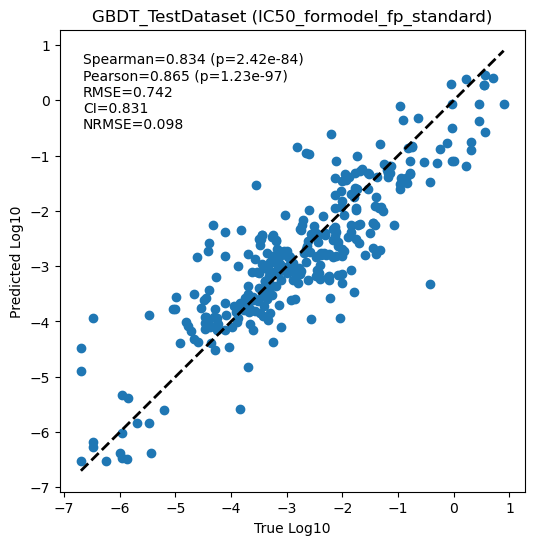

==== All done ====
CV results saved to: C:\ROOT\CK2 code\figure1D\parameter\GBDT_IC50_formodel_fp_standard_CVResults.csv
Model saved to: C:\ROOT\CK2 code\figure1D\parameter\GBDT_IC50_formodel_fp_standard_best_model.pkl
Plot saved to: C:\ROOT\CK2 code\figure1D\plot\GBDT_IC50_formodel_fp_standard_test.pdf
Summary saved to: C:\ROOT\CK2 code\figure1D\parameter\GBDT_summary.csv


,file,abs_path,n_samples_total,n_features,best_params,best_cv_neg_mse,test_spearman,test_spearman_p,test_pearson,test_pearson_p,test_rmse,test_ci,test_nrmse,cv_results_csv,model_pkl,test_plot_pdf
0,IC50_formodel_fp_standard.csv,C:\ROOT\CK2 code\figure1D\IC50_formodel_fp_sta...,1282,1024,"{'learning_rate': 0.01, 'max_depth': 6, 'n_est...",-0.530959,0.833903,2.422873e-84,0.865176,1.230109e-97,0.741534,0.83077,0.097639,C:\ROOT\CK2 code\figure1D\parameter\GBDT_IC50_...,C:\ROOT\CK2 code\figure1D\parameter\GBDT_IC50_...,C:\ROOT\CK2 code\figure1D\plot\GBDT_IC50_formo...


In [6]:
%matplotlib inline

# =========================
# Basic libraries / 基础库
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr, pearsonr
from lifelines.utils import concordance_index
import pickle


# ============================================================
# 1) Path configuration / 路径配置（根据本地环境自行修改）
# ============================================================
data_path = Path(r"C:\\ROOT\\CK2 code\\figure1D")

parameter_path = data_path / "parameter"
plot_path = data_path / "plot"

parameter_path.mkdir(parents=True, exist_ok=True)
plot_path.mkdir(parents=True, exist_ok=True)

# 单一输入文件（你现在的情况）
input_file = data_path / "IC50_formodel_fp_standard.csv"
if not input_file.exists():
    raise FileNotFoundError(f"Input file not found: {input_file}")

print("Input file:", input_file)


# ============================================================
# 2) Global configuration / 全局参数设置
# ============================================================
SPLIT_SEED = 0            # Random seed for train/test split / 数据集划分随机种子
MODEL_SEED = 42           # Random seed for model / 模型随机种子
TRAIN_SIZE = 0.75         # Train-test split ratio / 训练集比例

# Hyperparameter grid for GBDT / GBDT 网格搜索参数
param_grid = {
    "max_depth": [3, 6],
    "learning_rate": [0.01, 0.1],
    "n_estimators": [100, 1000],
}

drop_cols_default = [
    "Unnamed: 0",
    "realsmiles",
    "is_biochemical",
    "Log10",
    "is_cellbased",
    "id",
    "type",
    "value",
]


# ============================================================
# 3) Utility functions / 工具函数
# ============================================================
def safe_drop(df: pd.DataFrame, cols):
    """Safely drop columns that exist in the DataFrame."""
    cols_exist = [c for c in cols if c in df.columns]
    return df.drop(cols_exist, axis=1)


def compute_metrics(y_true, y_pred):
    """Compute evaluation metrics for regression."""
    sp = spearmanr(y_true, y_pred)
    pe = pearsonr(y_true, y_pred)
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))

    denom = float(np.max(y_true) - np.min(y_true))
    nrmse = float(rmse / denom) if denom != 0 else np.nan

    ci = float(concordance_index(y_true, y_pred))
    return sp, pe, rmse, nrmse, ci


def scatter_plot(y_true, y_pred, title, xlabel, ylabel, out_file: Path):
    """Generate scatter plot with performance statistics."""
    sp, pe, rmse, nrmse, ci = compute_metrics(y_true, y_pred)

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(y_true, y_pred)

    mn, mx = float(np.min(y_true)), float(np.max(y_true))
    ax.plot([mn, mx], [mn, mx], "k--", lw=2)

    text = (
        f"Spearman={sp.statistic:.3f} (p={sp.pvalue:.2e})\n"
        f"Pearson={pe.statistic:.3f} (p={pe.pvalue:.2e})\n"
        f"RMSE={rmse:.3f}\n"
        f"CI={ci:.3f}\n"
        f"NRMSE={nrmse:.3f}"
    )

    ax.text(
        0.05, 0.95, text,
        transform=ax.transAxes,
        ha="left", va="top",
        bbox={"facecolor": "white", "edgecolor": "none"},
    )

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    fig.savefig(out_file, dpi=500, bbox_inches="tight")
    plt.show()


# ============================================================
# 4) Main: load -> split -> grid search -> evaluate -> save
# ============================================================
tag = input_file.stem  # "IC50_formodel_fp_standard"

# Load dataset
df = pd.read_csv(input_file, sep=",")

# Column name normalization
if "is_cell.based" in df.columns and "is_cellbased" not in df.columns:
    df.rename(columns={"is_cell.based": "is_cellbased"}, inplace=True)

# Build X, y
if "Log10" not in df.columns:
    raise ValueError(f"{input_file.name} does not contain 'Log10' column.")

X = safe_drop(df, drop_cols_default)
y = df["Log10"].values

# Safety checks
assert X.select_dtypes(exclude=[np.number]).shape[1] == 0, f"{input_file.name}: X contains non-numeric columns!"
assert np.isfinite(X.to_numpy()).all(), f"{input_file.name}: X contains NaN/inf!"
assert np.isfinite(y).all(), f"{input_file.name}: y contains NaN/inf!"

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=TRAIN_SIZE, random_state=SPLIT_SEED
)

# GridSearchCV (GBDT)
base_model = GradientBoostingRegressor(random_state=MODEL_SEED)

grid = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=10,
    n_jobs=-1,
    verbose=1,
)

grid.fit(X_train, y_train)

# Save CV results
cv_results = pd.DataFrame(grid.cv_results_)
cv_results_out = parameter_path / f"GBDT_{tag}_CVResults.csv"
cv_results.to_csv(cv_results_out, index=False)

# Best model
best_model = grid.best_estimator_

# Test evaluation
y_pred_test = best_model.predict(X_test)
sp_te, pe_te, rmse_te, nrmse_te, ci_te = compute_metrics(y_test, y_pred_test)

# Save trained model
model_out = parameter_path / f"GBDT_{tag}_best_model.pkl"
with open(model_out, "wb") as f:
    pickle.dump(best_model, f)

# Plot
test_plot_out = plot_path / f"GBDT_{tag}_test.pdf"
scatter_plot(
    y_test,
    y_pred_test,
    title=f"GBDT_TestDataset ({tag})",
    xlabel="True Log10",
    ylabel="Predicted Log10",
    out_file=test_plot_out,
)

# Summary 
summary_df = pd.DataFrame([{
    "file": input_file.name,
    "abs_path": str(input_file),
    "n_samples_total": int(len(df)),
    "n_features": int(X.shape[1]),
    "best_params": grid.best_params_,
    "best_cv_neg_mse": float(grid.best_score_),
    "test_spearman": float(sp_te.statistic),
    "test_spearman_p": float(sp_te.pvalue),
    "test_pearson": float(pe_te.statistic),
    "test_pearson_p": float(pe_te.pvalue),
    "test_rmse": float(rmse_te),
    "test_ci": float(ci_te),
    "test_nrmse": float(nrmse_te),
    "cv_results_csv": str(cv_results_out),
    "model_pkl": str(model_out),
    "test_plot_pdf": str(test_plot_out),
}])

summary_out = parameter_path / "GBDT_summary.csv"
summary_df.to_csv(summary_out, index=False)

print("==== All done ====")
print("CV results saved to:", cv_results_out)
print("Model saved to:", model_out)
print("Plot saved to:", test_plot_out)
print("Summary saved to:", summary_out)

summary_df


In [7]:
### XGBoost model ###

Input file: C:\ROOT\CK2 code\figure1D\IC50_formodel_fp_standard.csv
Fitting 10 folds for each of 8 candidates, totalling 80 fits


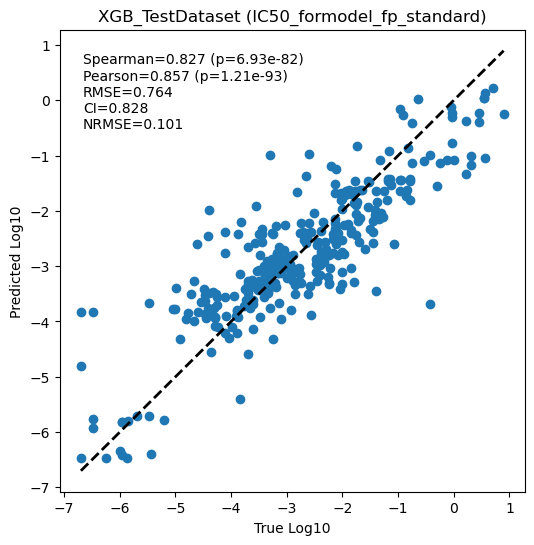

==== All done ====
CV results saved to: C:\ROOT\CK2 code\figure1D\parameter\XGB_IC50_formodel_fp_standard_CVResults.csv
Model saved to: C:\ROOT\CK2 code\figure1D\parameter\XGB_IC50_formodel_fp_standard_best_model.pkl
Plot saved to: C:\ROOT\CK2 code\figure1D\plot\XGB_IC50_formodel_fp_standard_test.pdf
Summary saved to: C:\ROOT\CK2 code\figure1D\parameter\XGB_summary.csv


,file,abs_path,n_samples_total,n_features,best_params,best_cv_neg_mse,test_spearman,test_spearman_p,test_pearson,test_pearson_p,test_rmse,test_ci,test_nrmse,cv_results_csv,model_pkl,test_plot_pdf
0,IC50_formodel_fp_standard.csv,C:\ROOT\CK2 code\figure1D\IC50_formodel_fp_sta...,1282,1024,"{'learning_rate': 0.01, 'max_depth': 4, 'n_est...",-0.53554,0.827293,6.929114e-82,0.856516,1.213867e-93,0.764013,0.828157,0.100599,C:\ROOT\CK2 code\figure1D\parameter\XGB_IC50_f...,C:\ROOT\CK2 code\figure1D\parameter\XGB_IC50_f...,C:\ROOT\CK2 code\figure1D\plot\XGB_IC50_formod...


In [8]:
%matplotlib inline

# =========================
# Basic libraries / 基础库
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr, pearsonr
from lifelines.utils import concordance_index
import pickle


# ============================================================
# 0) Import XGBoost / 导入 XGBoost
# ============================================================
try:
    from xgboost import XGBRegressor
except Exception as e:
    raise ImportError(
        "Failed to import xgboost. Please install it first:\n"
        "  pip install xgboost\n"
        f"Original error: {e}"
    )


# ============================================================
# 1) Path configuration / 路径配置（根据本地环境自行修改）
# ============================================================
data_path = Path(r"C:\\ROOT\\CK2 code\\figure1D")

parameter_path = data_path / "parameter"
plot_path = data_path / "plot"

parameter_path.mkdir(parents=True, exist_ok=True)
plot_path.mkdir(parents=True, exist_ok=True)

# 单一输入文件（你现在的情况）
input_file = data_path / "IC50_formodel_fp_standard.csv"
if not input_file.exists():
    raise FileNotFoundError(f"Input file not found: {input_file}")

print("Input file:", input_file)


# ============================================================
# 2) Global configuration / 全局参数设置
# ============================================================
SPLIT_SEED = 0            # Random seed for train/test split / 数据集划分随机种子
MODEL_SEED = 42           # Random seed for model / 模型随机种子
TRAIN_SIZE = 0.75         # Train-test split ratio / 训练集比例

# Hyperparameter grid for XGBoost / XGBoost 网格搜索参数
param_grid = {
    "max_depth": [4, 8],
    "learning_rate": [0.01, 0.1],
    "n_estimators": [500, 1000],
}

drop_cols_default = [
    "Unnamed: 0",
    "realsmiles",
    "is_biochemical",
    "Log10",
    "is_cellbased",
    "id",
    "type",
    "value",
]


# ============================================================
# 3) Utility functions / 工具函数
# ============================================================
def safe_drop(df: pd.DataFrame, cols):
    """Safely drop columns that exist in the DataFrame."""
    cols_exist = [c for c in cols if c in df.columns]
    return df.drop(cols_exist, axis=1)


def compute_metrics(y_true, y_pred):
    """Compute evaluation metrics for regression."""
    sp = spearmanr(y_true, y_pred)
    pe = pearsonr(y_true, y_pred)
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))

    denom = float(np.max(y_true) - np.min(y_true))
    nrmse = float(rmse / denom) if denom != 0 else np.nan

    ci = float(concordance_index(y_true, y_pred))
    return sp, pe, rmse, nrmse, ci


def scatter_plot(y_true, y_pred, title, xlabel, ylabel, out_file: Path):
    """Generate scatter plot with performance statistics."""
    sp, pe, rmse, nrmse, ci = compute_metrics(y_true, y_pred)

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(y_true, y_pred)

    mn, mx = float(np.min(y_true)), float(np.max(y_true))
    ax.plot([mn, mx], [mn, mx], "k--", lw=2)

    text = (
        f"Spearman={sp.statistic:.3f} (p={sp.pvalue:.2e})\n"
        f"Pearson={pe.statistic:.3f} (p={pe.pvalue:.2e})\n"
        f"RMSE={rmse:.3f}\n"
        f"CI={ci:.3f}\n"
        f"NRMSE={nrmse:.3f}"
    )

    ax.text(
        0.05, 0.95, text,
        transform=ax.transAxes,
        ha="left", va="top",
        bbox={"facecolor": "white", "edgecolor": "none"},
    )

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    fig.savefig(out_file, dpi=500, bbox_inches="tight")
    plt.show()


# ============================================================
# 4) Main: load -> split -> grid search -> evaluate -> save
# ============================================================
tag = input_file.stem  # "IC50_formodel_fp_standard"

# Load dataset / 读取数据
df = pd.read_csv(input_file, sep=",")

# Column name normalization / 列名规范化
if "is_cell.based" in df.columns and "is_cellbased" not in df.columns:
    df.rename(columns={"is_cell.based": "is_cellbased"}, inplace=True)

# Build X, y
if "Log10" not in df.columns:
    raise ValueError(f"{input_file.name} does not contain 'Log10' column.")

X = safe_drop(df, drop_cols_default)
y = df["Log10"].values

# Safety checks / 安全检查
assert X.select_dtypes(exclude=[np.number]).shape[1] == 0, f"{input_file.name}: X contains non-numeric columns!"
assert np.isfinite(X.to_numpy()).all(), f"{input_file.name}: X contains NaN/inf!"
assert np.isfinite(y).all(), f"{input_file.name}: y contains NaN/inf!"

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=TRAIN_SIZE, random_state=SPLIT_SEED
)

# Model training with grid search (XGBoost)
base_model = XGBRegressor(
    objective="reg:squarederror",
    eval_metric="rmse",
    random_state=MODEL_SEED,
    n_jobs=1,        # ✅ 更可复现（单线程）
    verbosity=0
)

grid = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=10,
    n_jobs=-1,       # 参数组合并行
    verbose=1,
)

grid.fit(X_train, y_train)

# Save CV results / 保存CV结果
cv_results = pd.DataFrame(grid.cv_results_)
cv_results_out = parameter_path / f"XGB_{tag}_CVResults.csv"
cv_results.to_csv(cv_results_out, index=False)

best_model = grid.best_estimator_

# Prediction and evaluation
y_pred_test = best_model.predict(X_test)
sp_te, pe_te, rmse_te, nrmse_te, ci_te = compute_metrics(y_test, y_pred_test)

# Save trained model / 保存模型
model_out = parameter_path / f"XGB_{tag}_best_model.pkl"
with open(model_out, "wb") as f:
    pickle.dump(best_model, f)

# Plot
test_plot_out = plot_path / f"XGB_{tag}_test.pdf"
scatter_plot(
    y_test,
    y_pred_test,
    title=f"XGB_TestDataset ({tag})",
    xlabel="True Log10",
    ylabel="Predicted Log10",
    out_file=test_plot_out,
)

# Summary 
summary_df = pd.DataFrame([{
    "file": input_file.name,
    "abs_path": str(input_file),
    "n_samples_total": int(len(df)),
    "n_features": int(X.shape[1]),
    "best_params": grid.best_params_,
    "best_cv_neg_mse": float(grid.best_score_),
    "test_spearman": float(sp_te.statistic),
    "test_spearman_p": float(sp_te.pvalue),
    "test_pearson": float(pe_te.statistic),
    "test_pearson_p": float(pe_te.pvalue),
    "test_rmse": float(rmse_te),
    "test_ci": float(ci_te),
    "test_nrmse": float(nrmse_te),
    "cv_results_csv": str(cv_results_out),
    "model_pkl": str(model_out),
    "test_plot_pdf": str(test_plot_out),
}])

summary_out = parameter_path / "XGB_summary.csv"
summary_df.to_csv(summary_out, index=False)

print("==== All done ====")
print("CV results saved to:", cv_results_out)
print("Model saved to:", model_out)
print("Plot saved to:", test_plot_out)
print("Summary saved to:", summary_out)

summary_df


In [9]:
### ANN model###

Input file: C:\ROOT\CK2 code\figure1D\IC50_formodel_fp_standard.csv
Fitting 10 folds for each of 16 candidates, totalling 160 fits


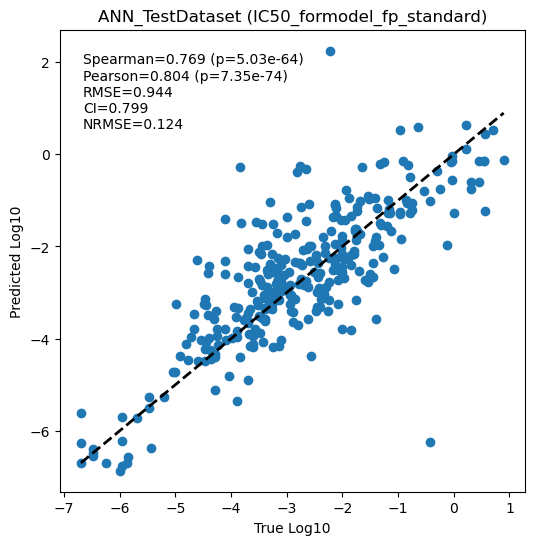

==== All done ====
CV results saved to: C:\ROOT\CK2 code\figure1D\parameter\ANN_IC50_formodel_fp_standard_CVResults.csv
Model saved to: C:\ROOT\CK2 code\figure1D\parameter\ANN_IC50_formodel_fp_standard_best_model.pkl
Plot saved to: C:\ROOT\CK2 code\figure1D\plot\ANN_IC50_formodel_fp_standard_test.pdf
Summary saved to: C:\ROOT\CK2 code\figure1D\parameter\ANN_summary.csv


,file,abs_path,n_samples_total,n_features,best_params,best_cv_neg_mse,test_spearman,test_spearman_p,test_pearson,test_pearson_p,test_rmse,test_ci,test_nrmse,cv_results_csv,model_pkl,test_plot_pdf
0,IC50_formodel_fp_standard.csv,C:\ROOT\CK2 code\figure1D\IC50_formodel_fp_sta...,1282,1024,"{'mlp__activation': 'tanh', 'mlp__alpha': 0.00...",-1.028188,0.769269,5.027000e-64,0.803562,7.349775e-74,0.9445,0.798982,0.124363,C:\ROOT\CK2 code\figure1D\parameter\ANN_IC50_f...,C:\ROOT\CK2 code\figure1D\parameter\ANN_IC50_f...,C:\ROOT\CK2 code\figure1D\plot\ANN_IC50_formod...


In [10]:
%matplotlib inline

# =========================
# Basic libraries / 基础库
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr, pearsonr
from lifelines.utils import concordance_index
import pickle


# ============================================================
# 1) Path configuration / 路径配置（根据本地环境自行修改）
# ============================================================
data_path = Path(r"C:\\ROOT\\CK2 code\\figure1D")

parameter_path = data_path / "parameter"
plot_path = data_path / "plot"

parameter_path.mkdir(parents=True, exist_ok=True)
plot_path.mkdir(parents=True, exist_ok=True)

# 单一输入文件（你现在的情况）
input_file = data_path / "IC50_formodel_fp_standard.csv"
if not input_file.exists():
    raise FileNotFoundError(f"Input file not found: {input_file}")

print("Input file:", input_file)


# ============================================================
# 2) Global configuration / 全局参数设置
# ============================================================
SPLIT_SEED = 0            # Random seed for train/test split / 数据集划分随机种子
MODEL_SEED = 42           # Random seed for model / 模型随机种子
TRAIN_SIZE = 0.75         # Train-test split ratio / 训练集比例

# Hyperparameter grid for ANN (MLPRegressor) / ANN（MLP）网格搜索参数
# NOTE: Because we use Pipeline, we need to prefix parameters with "mlp__".
param_grid = {
    "mlp__hidden_layer_sizes": [(50,), (100,)],
    "mlp__activation": ["identity", "tanh"],
    "mlp__alpha": [0.0001, 0.001],
    "mlp__learning_rate_init": [0.001, 0.01],
}

drop_cols_default = [
    "Unnamed: 0",
    "realsmiles",
    "is_biochemical",
    "Log10",
    "is_cellbased",
    "id",
    "type",
    "value",
]


# ============================================================
# 3) Utility functions / 工具函数
# ============================================================
def safe_drop(df: pd.DataFrame, cols):
    """Safely drop columns that exist in the DataFrame."""
    cols_exist = [c for c in cols if c in df.columns]
    return df.drop(cols_exist, axis=1)


def compute_metrics(y_true, y_pred):
    """Compute evaluation metrics for regression."""
    sp = spearmanr(y_true, y_pred)
    pe = pearsonr(y_true, y_pred)
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))

    denom = float(np.max(y_true) - np.min(y_true))
    nrmse = float(rmse / denom) if denom != 0 else np.nan

    ci = float(concordance_index(y_true, y_pred))
    return sp, pe, rmse, nrmse, ci


def scatter_plot(y_true, y_pred, title, xlabel, ylabel, out_file: Path):
    """Generate scatter plot with performance statistics."""
    sp, pe, rmse, nrmse, ci = compute_metrics(y_true, y_pred)

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(y_true, y_pred)

    mn, mx = float(np.min(y_true)), float(np.max(y_true))
    ax.plot([mn, mx], [mn, mx], "k--", lw=2)

    text = (
        f"Spearman={sp.statistic:.3f} (p={sp.pvalue:.2e})\n"
        f"Pearson={pe.statistic:.3f} (p={pe.pvalue:.2e})\n"
        f"RMSE={rmse:.3f}\n"
        f"CI={ci:.3f}\n"
        f"NRMSE={nrmse:.3f}"
    )

    ax.text(
        0.05, 0.95, text,
        transform=ax.transAxes,
        ha="left", va="top",
        bbox={"facecolor": "white", "edgecolor": "none"},
    )

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    fig.savefig(out_file, dpi=500, bbox_inches="tight")
    plt.show()


# ============================================================
# 4) Main: load -> split -> grid search -> evaluate -> save
# ============================================================
tag = input_file.stem  # "IC50_formodel_fp_standard"

# Load dataset
df = pd.read_csv(input_file, sep=",")

# Column name normalization
if "is_cell.based" in df.columns and "is_cellbased" not in df.columns:
    df.rename(columns={"is_cell.based": "is_cellbased"}, inplace=True)

# Feature matrix and target vector
if "Log10" not in df.columns:
    raise ValueError(f"{input_file.name} does not contain 'Log10' column.")

X = safe_drop(df, drop_cols_default)
y = df["Log10"].values

# Safety checks
assert X.select_dtypes(exclude=[np.number]).shape[1] == 0, f"{input_file.name}: X contains non-numeric columns!"
assert np.isfinite(X.to_numpy()).all(), f"{input_file.name}: X contains NaN/inf!"
assert np.isfinite(y).all(), f"{input_file.name}: y contains NaN/inf!"

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=TRAIN_SIZE, random_state=SPLIT_SEED
)

# Model training with grid search (ANN / MLPRegressor)
pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("mlp", MLPRegressor(
        random_state=MODEL_SEED,
        max_iter=2000,
        early_stopping=True,
        n_iter_no_change=20,
    ))
])

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=10,
    n_jobs=-1,
    verbose=1,
)

grid.fit(X_train, y_train)

# Save CV results
cv_results = pd.DataFrame(grid.cv_results_)
cv_results_out = parameter_path / f"ANN_{tag}_CVResults.csv"
cv_results.to_csv(cv_results_out, index=False)

best_model = grid.best_estimator_  # includes scaler + mlp

# Test evaluation
y_pred_test = best_model.predict(X_test)
sp_te, pe_te, rmse_te, nrmse_te, ci_te = compute_metrics(y_test, y_pred_test)

# Save trained model
model_out = parameter_path / f"ANN_{tag}_best_model.pkl"
with open(model_out, "wb") as f:
    pickle.dump(best_model, f)

# Plot
test_plot_out = plot_path / f"ANN_{tag}_test.pdf"
scatter_plot(
    y_test,
    y_pred_test,
    title=f"ANN_TestDataset ({tag})",
    xlabel="True Log10",
    ylabel="Predicted Log10",
    out_file=test_plot_out,
)

# Summary
summary_df = pd.DataFrame([{
    "file": input_file.name,
    "abs_path": str(input_file),
    "n_samples_total": int(len(df)),
    "n_features": int(X.shape[1]),
    "best_params": grid.best_params_,
    "best_cv_neg_mse": float(grid.best_score_),
    "test_spearman": float(sp_te.statistic),
    "test_spearman_p": float(sp_te.pvalue),
    "test_pearson": float(pe_te.statistic),
    "test_pearson_p": float(pe_te.pvalue),
    "test_rmse": float(rmse_te),
    "test_ci": float(ci_te),
    "test_nrmse": float(nrmse_te),
    "cv_results_csv": str(cv_results_out),
    "model_pkl": str(model_out),
    "test_plot_pdf": str(test_plot_out),
}])

summary_out = parameter_path / "ANN_summary.csv"
summary_df.to_csv(summary_out, index=False)

print("==== All done ====")
print("CV results saved to:", cv_results_out)
print("Model saved to:", model_out)
print("Plot saved to:", test_plot_out)
print("Summary saved to:", summary_out)

summary_df


In [11]:
###Voting SVM, GBDT, XGBoost model ###

Input file: C:\ROOT\CK2 code\figure1D\IC50_formodel_fp_standard.csv
Fitting 10 folds for each of 18 candidates, totalling 180 fits


D:\CondaStore\envs\knn-env\lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Fitting 10 folds for each of 8 candidates, totalling 80 fits
Fitting 10 folds for each of 8 candidates, totalling 80 fits


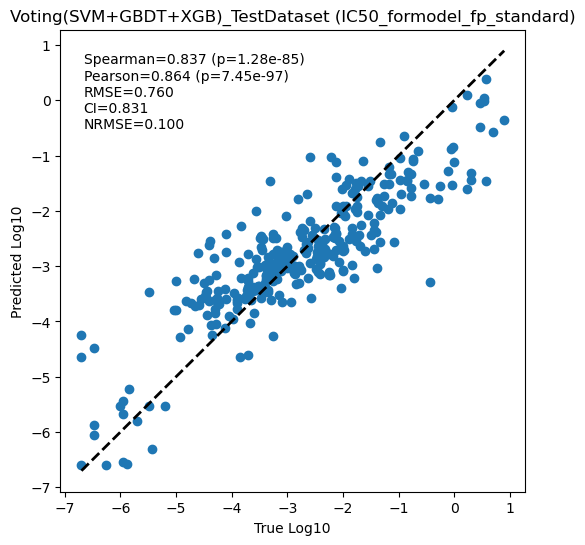

==== All done ====
SVM CV saved to: C:\ROOT\CK2 code\figure1D\parameter\SVM_IC50_formodel_fp_standard_CVResults.csv
GBDT CV saved to: C:\ROOT\CK2 code\figure1D\parameter\GBDT_IC50_formodel_fp_standard_CVResults.csv
XGB CV saved to: C:\ROOT\CK2 code\figure1D\parameter\XGB_IC50_formodel_fp_standard_CVResults.csv
Ensemble model saved to: C:\ROOT\CK2 code\figure1D\parameter\Voting_SVM_GBDT_XGB_IC50_formodel_fp_standard_best_model.pkl
Plot saved to: C:\ROOT\CK2 code\figure1D\plot\Voting_SVM_GBDT_XGB_IC50_formodel_fp_standard_test.pdf
Summary saved to: C:\ROOT\CK2 code\figure1D\parameter\Voting_SVM_GBDT_XGB_summary.csv


,file,abs_path,n_samples_total,n_features,best_svm_params,best_gbdt_params,best_xgb_params,voting_params,voting_best_cv_neg_mse,test_spearman,...,test_pearson_p,test_rmse,test_ci,test_nrmse,svm_cv_results_csv,gbdt_cv_results_csv,xgb_cv_results_csv,voting_cv_results_csv,ensemble_model_pkl,test_plot_pdf
0,IC50_formodel_fp_standard.csv,C:\ROOT\CK2 code\figure1D\IC50_formodel_fp_sta...,1282,1024,"{'svr__C': 10, 'svr__gamma': 0.01, 'svr__kerne...","{'learning_rate': 0.01, 'max_depth': 6, 'n_est...","{'learning_rate': 0.01, 'max_depth': 4, 'n_est...","{'weights': (1, 1, 1)}",NaN,0.837229,...,7.450690e-97,0.759787,0.831169,0.100042,C:\ROOT\CK2 code\figure1D\parameter\SVM_IC50_f...,C:\ROOT\CK2 code\figure1D\parameter\GBDT_IC50_...,C:\ROOT\CK2 code\figure1D\parameter\XGB_IC50_f...,,C:\ROOT\CK2 code\figure1D\parameter\Voting_SVM...,C:\ROOT\CK2 code\figure1D\plot\Voting_SVM_GBDT...


In [12]:
%matplotlib inline

# =========================
# Basic libraries / 基础库
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, VotingRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr, pearsonr
from lifelines.utils import concordance_index
import pickle

# ============================================================
# Import XGBoost / 导入 XGBoost
# ============================================================
try:
    from xgboost import XGBRegressor
except Exception as e:
    raise ImportError(
        "Failed to import xgboost. Please install it first:\n"
        "  pip install xgboost\n"
        f"Original error: {e}"
    )


# ============================================================
# 1) Path configuration / 路径配置
# ============================================================
data_path = Path(r"C:\\ROOT\\CK2 code\\figure1D")
parameter_path = data_path / "parameter"
plot_path = data_path / "plot"
parameter_path.mkdir(parents=True, exist_ok=True)
plot_path.mkdir(parents=True, exist_ok=True)

input_file = data_path / "IC50_formodel_fp_standard.csv"
if not input_file.exists():
    raise FileNotFoundError(f"Input file not found: {input_file}")

print("Input file:", input_file)


# ============================================================
# 2) Global configuration / 全局参数
# ============================================================
SPLIT_SEED = 0
MODEL_SEED = 42
TRAIN_SIZE = 0.75

drop_cols_default = [
    "Unnamed: 0",
    "realsmiles",
    "is_biochemical",
    "Log10",
    "is_cellbased",
    "id",
    "type",
    "value",
]

# --- individual model grids ---
# SVM：用Pipeline所以需要 "svr__" 前缀
svm_param_grid = {
    "svr__C": [0.1, 1, 10],
    "svr__kernel": ["linear", "rbf"],
    "svr__gamma": [1, 0.1, 0.01],
}

gbdt_param_grid = {
    "max_depth": [3, 6],
    "learning_rate": [0.01, 0.1],
    "n_estimators": [100, 1000],
}

xgb_param_grid = {
    "max_depth": [4, 8],
    "learning_rate": [0.01, 0.1],
    "n_estimators": [500, 1000],
}

# 是否对 Voting 的 weights 做网格搜索（可选）
SEARCH_VOTING_WEIGHTS = False
voting_weights_grid = {
    "weights": [
        (1, 1, 1),
        (2, 1, 1),
        (1, 2, 1),
        (1, 1, 2),
        (2, 2, 1),
        (2, 1, 2),
        (1, 2, 2),
        (3, 1, 1),
        (1, 3, 1),
        (1, 1, 3),
    ]
}


# ============================================================
# 3) Utility functions / 工具函数
# ============================================================
def safe_drop(df: pd.DataFrame, cols):
    cols_exist = [c for c in cols if c in df.columns]
    return df.drop(cols_exist, axis=1)

def compute_metrics(y_true, y_pred):
    sp = spearmanr(y_true, y_pred)
    pe = pearsonr(y_true, y_pred)
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))

    denom = float(np.max(y_true) - np.min(y_true))
    nrmse = float(rmse / denom) if denom != 0 else np.nan

    ci = float(concordance_index(y_true, y_pred))
    return sp, pe, rmse, nrmse, ci

def scatter_plot(y_true, y_pred, title, xlabel, ylabel, out_file: Path):
    sp, pe, rmse, nrmse, ci = compute_metrics(y_true, y_pred)

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(y_true, y_pred)

    mn, mx = float(np.min(y_true)), float(np.max(y_true))
    ax.plot([mn, mx], [mn, mx], "k--", lw=2)

    text = (
        f"Spearman={sp.statistic:.3f} (p={sp.pvalue:.2e})\n"
        f"Pearson={pe.statistic:.3f} (p={pe.pvalue:.2e})\n"
        f"RMSE={rmse:.3f}\n"
        f"CI={ci:.3f}\n"
        f"NRMSE={nrmse:.3f}"
    )

    ax.text(
        0.05, 0.95, text,
        transform=ax.transAxes,
        ha="left", va="top",
        bbox={"facecolor": "white", "edgecolor": "none"},
    )

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    fig.savefig(out_file, dpi=500, bbox_inches="tight")
    plt.show()


# ============================================================
# 4) Load data / 读取数据
# ============================================================
tag = input_file.stem  # "IC50_formodel_fp_standard"

df = pd.read_csv(input_file, sep=",")

if "is_cell.based" in df.columns and "is_cellbased" not in df.columns:
    df.rename(columns={"is_cell.based": "is_cellbased"}, inplace=True)

if "Log10" not in df.columns:
    raise ValueError(f"{input_file.name} does not contain 'Log10' column.")

X = safe_drop(df, drop_cols_default)
y = df["Log10"].values

assert X.select_dtypes(exclude=[np.number]).shape[1] == 0, f"{input_file.name}: X contains non-numeric columns!"
assert np.isfinite(X.to_numpy()).all(), f"{input_file.name}: X contains NaN/inf!"
assert np.isfinite(y).all(), f"{input_file.name}: y contains NaN/inf!"

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=TRAIN_SIZE, random_state=SPLIT_SEED
)


# ============================================================
# 5) Train three base models (GridSearchCV) / 三个基模型分别网格搜索
# ============================================================

# ---- 5.1 SVM (scaled) ----
svm_pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("svr", SVR())
])

svm_grid = GridSearchCV(
    estimator=svm_pipe,
    param_grid=svm_param_grid,
    scoring="neg_mean_squared_error",
    cv=10,
    n_jobs=-1,
    verbose=1,
)
svm_grid.fit(X_train, y_train)

svm_cv_out = parameter_path / f"SVM_{tag}_CVResults.csv"
pd.DataFrame(svm_grid.cv_results_).to_csv(svm_cv_out, index=False)
best_svm = svm_grid.best_estimator_

# ---- 5.2 GBDT ----
gbdt_base = GradientBoostingRegressor(random_state=MODEL_SEED)
gbdt_grid = GridSearchCV(
    estimator=gbdt_base,
    param_grid=gbdt_param_grid,
    scoring="neg_mean_squared_error",
    cv=10,
    n_jobs=-1,
    verbose=1,
)
gbdt_grid.fit(X_train, y_train)

gbdt_cv_out = parameter_path / f"GBDT_{tag}_CVResults.csv"
pd.DataFrame(gbdt_grid.cv_results_).to_csv(gbdt_cv_out, index=False)
best_gbdt = gbdt_grid.best_estimator_

# ---- 5.3 XGBoost ----
xgb_base = XGBRegressor(
    objective="reg:squarederror",
    eval_metric="rmse",
    random_state=MODEL_SEED,
    n_jobs=1,      # 单次训练更可复现
    verbosity=0
)

xgb_grid = GridSearchCV(
    estimator=xgb_base,
    param_grid=xgb_param_grid,
    scoring="neg_mean_squared_error",
    cv=10,
    n_jobs=-1,     # 参数组合并行
    verbose=1,
)
xgb_grid.fit(X_train, y_train)

xgb_cv_out = parameter_path / f"XGB_{tag}_CVResults.csv"
pd.DataFrame(xgb_grid.cv_results_).to_csv(xgb_cv_out, index=False)
best_xgb = xgb_grid.best_estimator_


# ============================================================
# 6) Voting ensemble / 投票集成
# ============================================================
voting = VotingRegressor(
    estimators=[
        ("svm", best_svm),
        ("gbdt", best_gbdt),
        ("xgb", best_xgb),
    ],
    weights=None  # 默认等权
)

if SEARCH_VOTING_WEIGHTS:
    # 对集成权重做一个小范围搜索（可选）
    voting_grid = GridSearchCV(
        estimator=voting,
        param_grid=voting_weights_grid,
        scoring="neg_mean_squared_error",
        cv=10,
        n_jobs=-1,
        verbose=1,
    )
    voting_grid.fit(X_train, y_train)
    best_voting = voting_grid.best_estimator_

    voting_cv_out = parameter_path / f"Voting_SVM_GBDT_XGB_{tag}_CVResults.csv"
    pd.DataFrame(voting_grid.cv_results_).to_csv(voting_cv_out, index=False)

    best_voting_params = voting_grid.best_params_
    best_voting_cv = float(voting_grid.best_score_)
else:
    # 不做权重搜索：直接fit
    best_voting = voting.fit(X_train, y_train)
    voting_cv_out = None
    best_voting_params = {"weights": (1, 1, 1)}
    best_voting_cv = np.nan


# ============================================================
# 7) Evaluation + save / 评估与保存
# ============================================================
y_pred_test = best_voting.predict(X_test)
sp_te, pe_te, rmse_te, nrmse_te, ci_te = compute_metrics(y_test, y_pred_test)

# Save ensemble model
model_out = parameter_path / f"Voting_SVM_GBDT_XGB_{tag}_best_model.pkl"
with open(model_out, "wb") as f:
    pickle.dump(best_voting, f)

# Plot
test_plot_out = plot_path / f"Voting_SVM_GBDT_XGB_{tag}_test.pdf"
scatter_plot(
    y_test,
    y_pred_test,
    title=f"Voting(SVM+GBDT+XGB)_TestDataset ({tag})",
    xlabel="True Log10",
    ylabel="Predicted Log10",
    out_file=test_plot_out,
)

# Summary
summary_df = pd.DataFrame([{
    "file": input_file.name,
    "abs_path": str(input_file),
    "n_samples_total": int(len(df)),
    "n_features": int(X.shape[1]),

    "best_svm_params": svm_grid.best_params_,
    "best_gbdt_params": gbdt_grid.best_params_,
    "best_xgb_params": xgb_grid.best_params_,

    "voting_params": best_voting_params,
    "voting_best_cv_neg_mse": best_voting_cv,

    "test_spearman": float(sp_te.statistic),
    "test_spearman_p": float(sp_te.pvalue),
    "test_pearson": float(pe_te.statistic),
    "test_pearson_p": float(pe_te.pvalue),
    "test_rmse": float(rmse_te),
    "test_ci": float(ci_te),
    "test_nrmse": float(nrmse_te),

    "svm_cv_results_csv": str(svm_cv_out),
    "gbdt_cv_results_csv": str(gbdt_cv_out),
    "xgb_cv_results_csv": str(xgb_cv_out),
    "voting_cv_results_csv": str(voting_cv_out) if voting_cv_out else "",
    "ensemble_model_pkl": str(model_out),
    "test_plot_pdf": str(test_plot_out),
}])

summary_out = parameter_path / "Voting_SVM_GBDT_XGB_summary.csv"
summary_df.to_csv(summary_out, index=False)

print("==== All done ====")
print("SVM CV saved to:", svm_cv_out)
print("GBDT CV saved to:", gbdt_cv_out)
print("XGB CV saved to:", xgb_cv_out)
if voting_cv_out:
    print("Voting CV saved to:", voting_cv_out)
print("Ensemble model saved to:", model_out)
print("Plot saved to:", test_plot_out)
print("Summary saved to:", summary_out)

summary_df
